# Data Analysis and Preprocessing

## Necessary package imports

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter

In [199]:
# Load the dataset and check that it's loaded in correctly
df = pd.read_csv('healthcare-dataset-stroke-data.csv', index_col=False)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Incomplete data

In [200]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [201]:
# We see that some of the bmi values are missing. we count the number of missing bmi values to determine if we should replace them with the mean
# or if we can discard the data entries that are incomplete if it is a small percentage

# Calculate the how many percent of the total bmi values that are missing
missing_bmi_count = df['bmi'].isnull().sum()
missing_bmi_percentage = (missing_bmi_count / len(df)) * 100

# Display the results
print(f"Amount of missing BMI values: {missing_bmi_count}")
print(f"Percentage of missing BMI values: {missing_bmi_percentage:.2f}%")


# If the percentage of missing values is less than 5% it is removed from the dataset
if missing_bmi_percentage < 5:
    df = df.dropna(subset=['bmi'])
else:
    # Alternatively, you could impute these values (e.g., with mean or median)
    df['bmi'] = df['bmi'].fillna(df['bmi'].mean())


# Check that they the rows with missing bmi have been removed
print(f"Remaining rows in dataset: {len(df)}")

Amount of missing BMI values: 201
Percentage of missing BMI values: 3.93%
Remaining rows in dataset: 4909


Since it's such a small part of the dataset that is incomplete we can remove the entries that are missing the bmi values without losing much information 

In [202]:
# separate the target from the paramaters and remove the id as it should not have any correlation to the target
parameters = df.columns.drop(["id", "stroke"])

print ("\n parameters:")
for parameter in parameters:
    print(parameter) 


 parameters:
gender
age
hypertension
heart_disease
ever_married
work_type
Residence_type
avg_glucose_level
bmi
smoking_status


## Examine the data

/var/folders/v9/lmnp2xk57p793ms7knv4fxqc0000gn/T/ipykernel_4405/3544268574.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['stroke'], palette=['blue', 'red'])


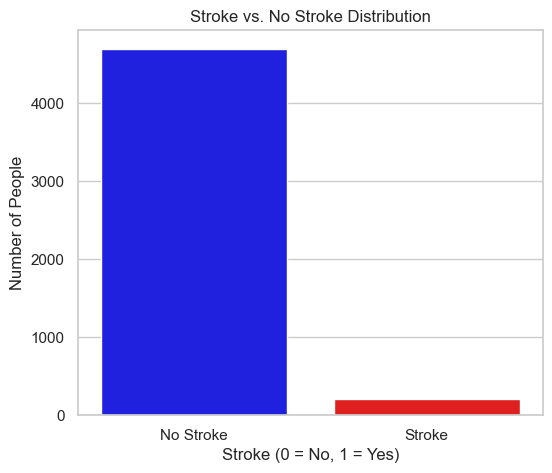

In [203]:
# Show the amount of entries of people who have gotten a stroke and the amount of people who have not gotten a stroke
plt.figure(figsize=(6, 5))
sns.countplot(x=df['stroke'], palette=['blue', 'red']) 
plt.xlabel("Stroke (0 = No, 1 = Yes)")
plt.ylabel("Number of People")
plt.title("Stroke vs. No Stroke Distribution")
plt.xticks([0, 1], ["No Stroke", "Stroke"]) 
plt.show()

##### The target class is very imbalanced with a much larger number of instances where individuals have not had a stroke compared to those who have

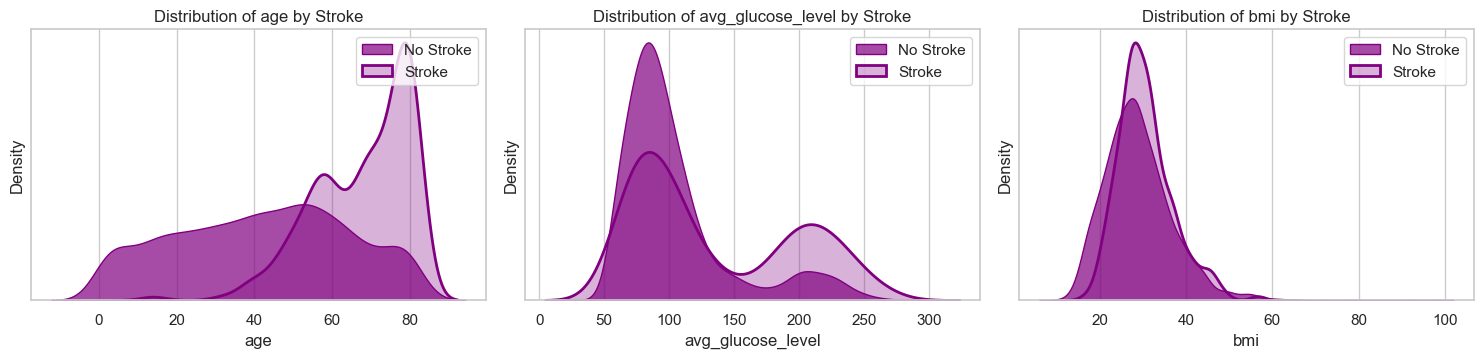

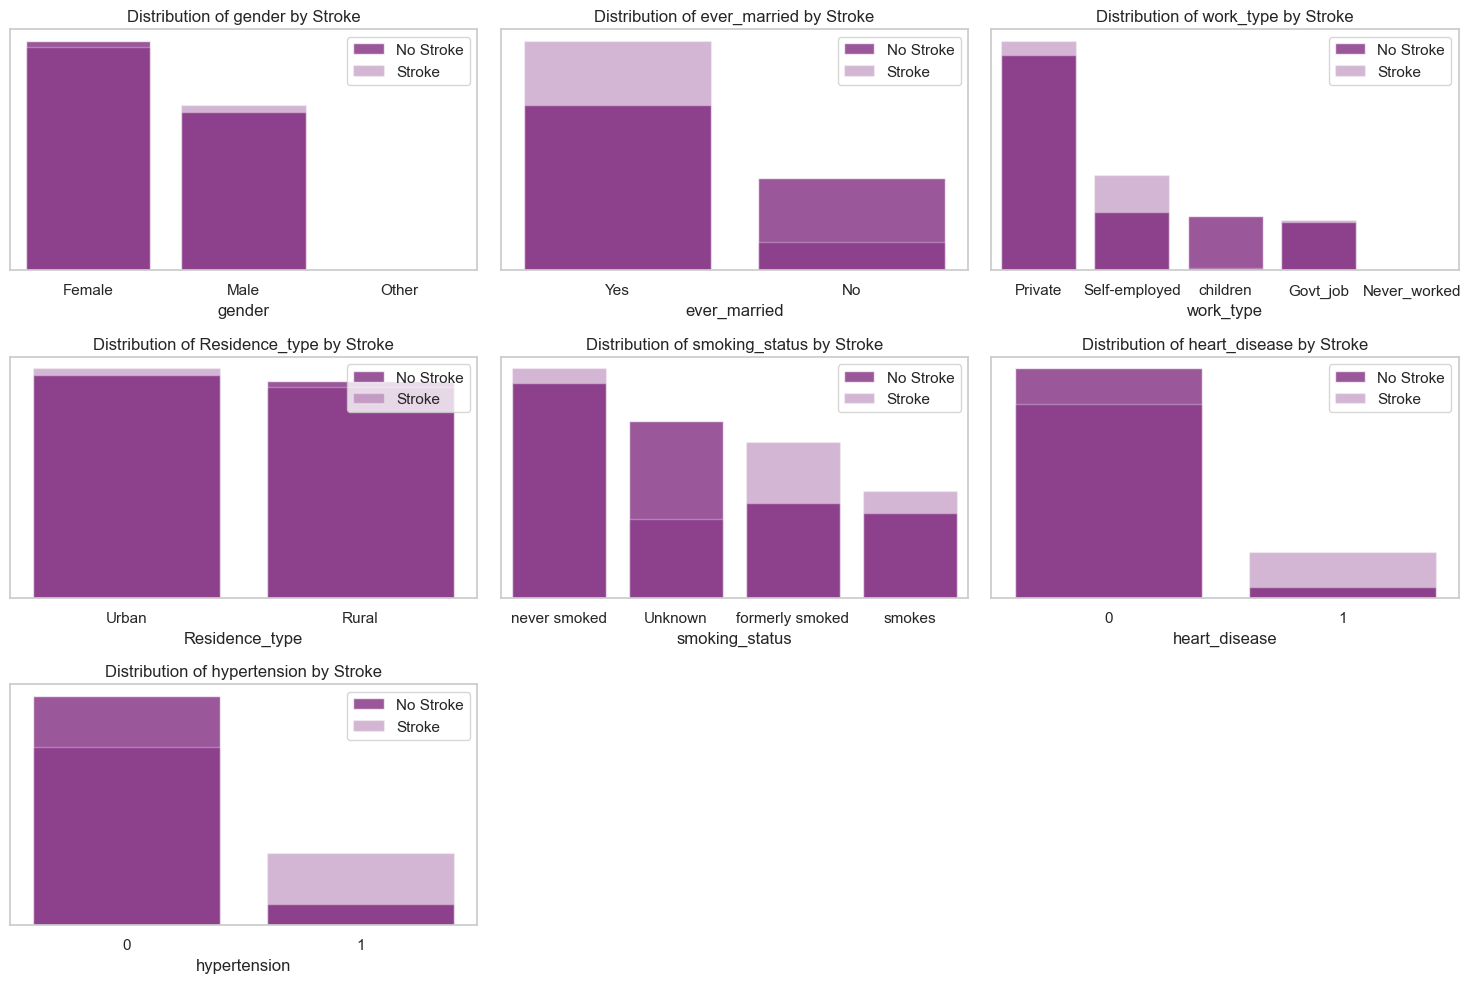

In [204]:
sns.set(style="whitegrid")

# Exclude 'id' and 'stroke' from numerical columns as we don't want the target class, the id should be irrelevant and heart disease and hypertension
# are better represented as a categorical feature as they can only be 0 or 1
exclude_columns = ['id', 'stroke', 'hypertension', 'heart_disease']
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

# Normalize stroke cases for better visibility
stroke_weight = len(df[df['stroke'] == 0]) / len(df[df['stroke'] == 1])

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.kdeplot(df[df['stroke'] == 0][column], color='purple', alpha=0.7, label='No Stroke', fill=True)
    sns.kdeplot(df[df['stroke'] == 1][column], color='purple', alpha=0.3, label='Stroke', fill=True, linewidth=2, 
                common_norm=False, bw_adjust=0.8)  
    plt.title(f'Distribution of {column} by Stroke')
    plt.xlabel(column)
    plt.yticks([])
    plt.legend()

plt.tight_layout()
plt.show()

categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col not in exclude_columns]

# Add heart disease and hypertension to categorical features as they are either 0 or 1
categorical_columns.extend(['heart_disease', 'hypertension'])

plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    
    no_stroke_counts = df[df['stroke'] == 0][column].value_counts()
    stroke_counts = df[df['stroke'] == 1][column].value_counts() * stroke_weight
    
    sns.barplot(x=no_stroke_counts.index, y=no_stroke_counts.values, color='purple', alpha=0.7, label="No Stroke")
    sns.barplot(x=stroke_counts.index, y=stroke_counts.values, color='purple', alpha=0.3, label="Stroke")

    plt.title(f'Distribution of {column} by Stroke')
    plt.xlabel(column)
    plt.yticks([])
    plt.legend()

plt.tight_layout()
plt.show()


##### From these plots we can see that the most important feature to determine the risk of someone getting a stroke is someones age followed by their average glucose level. We can also see that hypertension and heart disease seems to be features of high importance.

## Data Preprocessing and Feature Engineering
We can create new features from existing ones to simplify the model and show trends across different values. For example we can introduce a new feature "age groups" which transforms age from a numerical variable into a categorical one.

In [205]:
# Divide the age feature into different age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 70, np.inf], labels=['0-29', '30-49', '50-69', '70+'])
parameters = df.columns.drop('age')

# use one-hot encoding for the age groups
df = pd.get_dummies(df, columns=['age_group'], drop_first=False)

In [206]:
# Encode the categorical features so that they can be used in our model

label_enc = LabelEncoder()
df['gender'] = label_enc.fit_transform(df['gender'])
df['Residence_type'] = label_enc.fit_transform(df['Residence_type'])
df['work_type'] = label_enc.fit_transform(df['work_type'])
df['ever_married'] = label_enc.fit_transform(df['work_type'])
df['smoking_status'] = label_enc.fit_transform(df['work_type'])

0       False
2        True
3       False
4        True
5        True
        ...  
5104    False
5106     True
5107    False
5108    False
5109    False
Name: age_group_70+, Length: 4909, dtype: bool
New class balance after SMOTE: Counter({0: 3763, 1: 3763})
7526


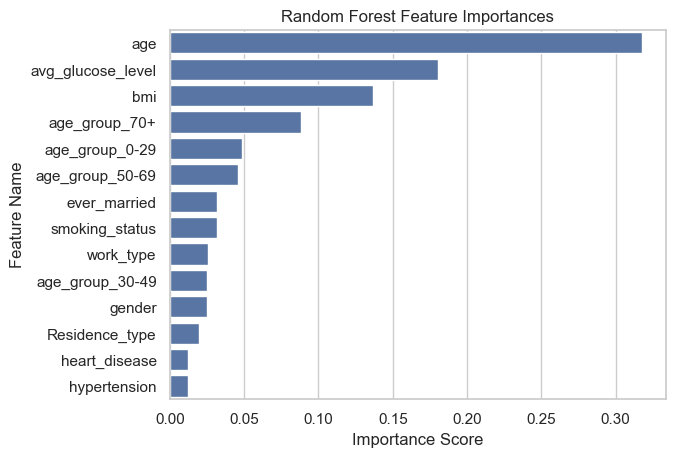

In [207]:
clf = RandomForestClassifier(random_state=21)


print(df.iloc[:, -1])
X_train, X_test, y_train, y_test = train_test_split(df.drop(['stroke', 'id'], axis=1),df['stroke'], test_size=0.2, random_state=20)

# oversample the minority class with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=5)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("New class balance after SMOTE:", Counter(y_train))

print(len(X_train))
clf.fit(X_train, y_train)

parameters = X_train.columns
feature_scores = pd.Series(clf.feature_importances_, index = parameters).sort_values(ascending = False)

sns.barplot(x=feature_scores, y=feature_scores.index)

plt.title("Random Forest Feature Importances")
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

From the graph above we can see that transforming the age feature into a categorical feature seems to have a different effect than intended. The importance of these new features are all very low which is not in line with what we could see when plotting the trends. So we decide to instead the age group features and move forward using age instead

7526


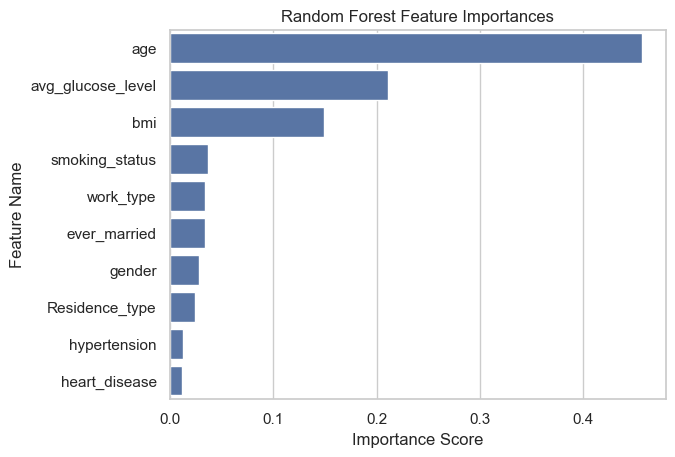

In [208]:
# Drop the transformed features
X_train = X_train.drop(['age_group_70+', 'age_group_50-69', 'age_group_0-29', 'age_group_30-49'], axis=1)
X_test = X_test.drop(['age_group_70+', 'age_group_50-69', 'age_group_0-29', 'age_group_30-49'], axis=1)

#plot the importance scores again since we have now modified the data
print(len(X_train))
clf.fit(X_train, y_train)

parameters = X_train.columns
feature_scores = pd.Series(clf.feature_importances_, index = parameters).sort_values(ascending = False)

sns.barplot(x=feature_scores, y=feature_scores.index)

plt.title("Random Forest Feature Importances")
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

We can also drop the features that have a low importance score. The threshold of low importance is set at 5 %

In [209]:
threshold = np.percentile(feature_scores, 5)
important_features = feature_scores[feature_scores >= threshold].index.tolist()

X_train = X_train[important_features]
X_test = X_test[important_features]

We can now scale the data so the models perform as expected

In [210]:
# Standardize features
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

## Model Implementation
Now that we have reduced our data we can start implementing and evaluating some models. We can do this by creating a function to evaluate differenet models

In [211]:
def evaluate_model(model, X_tr, X_te, y_tr, y_te, model_name="Model"):
    model.fit(X_tr, y_tr)
    
    y_pred = model.predict(X_te)
    
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred)
    rec = recall_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    
    print(f"\n--- {model_name} ---")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("\nClassification Report:\n", classification_report(y_te, y_pred))
    
    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return acc  # Return accuracy for model comparison


--- Logistic Regression ---
Accuracy: 0.7606924643584522
Precision: 0.11382113821138211
Recall: 0.6222222222222222
F1 Score: 0.19243986254295534

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.77      0.86       937
           1       0.11      0.62      0.19        45

    accuracy                           0.76       982
   macro avg       0.55      0.69      0.53       982
weighted avg       0.94      0.76      0.83       982



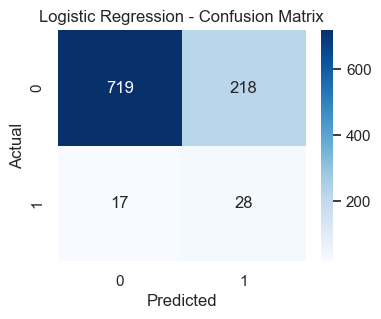


--- K-Nearest Neighbors ---
Accuracy: 0.8116089613034623
Precision: 0.10674157303370786
Recall: 0.4222222222222222
F1 Score: 0.17040358744394618

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.83      0.89       937
           1       0.11      0.42      0.17        45

    accuracy                           0.81       982
   macro avg       0.54      0.63      0.53       982
weighted avg       0.93      0.81      0.86       982



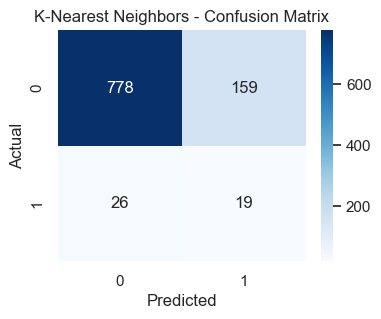


--- Random Forest ---
Accuracy: 0.8971486761710794
Precision: 0.12162162162162163
Recall: 0.2
F1 Score: 0.15126050420168066

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       937
           1       0.12      0.20      0.15        45

    accuracy                           0.90       982
   macro avg       0.54      0.57      0.55       982
weighted avg       0.92      0.90      0.91       982



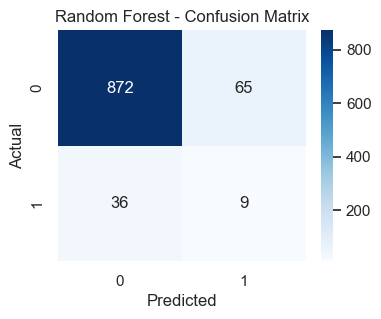

Model Accuracies: {'Logistic Regression': 0.7606924643584522, 'K-Nearest Neighbors': 0.8116089613034623, 'Random Forest': 0.8971486761710794}


In [219]:
log_reg = LogisticRegression(max_iter=1000, random_state=21)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=21)

# Evaluate each model on the reduced feature set.
acc_log_reg = evaluate_model(log_reg, X_train, X_test, y_train, y_test, "Logistic Regression")
acc_knn = evaluate_model(knn, X_train, X_test, y_train, y_test, "K-Nearest Neighbors")
acc_rf = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")

# Compare accuracies
model_accuracies = {"Logistic Regression": acc_log_reg, "K-Nearest Neighbors": acc_knn, "Random Forest": acc_rf}
print("Model Accuracies:", model_accuracies)

From this we can see that the random forest model has the best accuracy but in terms of recall, precision and f1-score it performs terribly. So the best model depends on what the user prioritizes.

We can tune the models hyperparameters to achieve a better result

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 0.9496436240852196

--- Tuned Random Forest ---
Accuracy: 0.8961303462321792
Precision: 0.12987012987012986
Recall: 0.2222222222222222
F1 Score: 0.16393442622950818

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       937
           1       0.13      0.22      0.16        45

    accuracy                           0.90       982
   macro avg       0.55      0.58      0.55       982
weighted avg       0.92      0.90      0.91       982



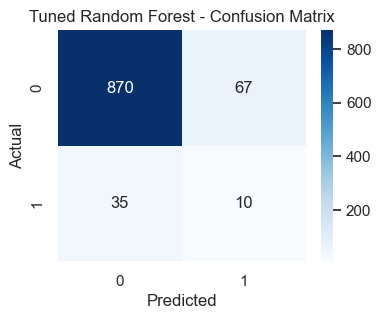

0.8961303462321792

In [213]:
# Tuning random forest
random_forest_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_tune = RandomForestClassifier(random_state=21)

grid_search = GridSearchCV(estimator=rf_tune, param_grid=random_forest_param_grid, cv=10, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

tuned_rf = RandomForestClassifier(max_depth='None', min_samples_leaf=1, min_samples_split=2, n_estimators=200)
tuned_rf.fit(X_train, y_train)
evaluate_model(tuned_rf, X_train, X_test, y_train, y_test, "Tuned Random Forest")

In [217]:
logistic_regression_params = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'solver': ['liblinear', 'lbfgs', 'newton-cg'] 
}

grid_search = GridSearchCV(log_reg, logistic_regression_params, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)



Best Hyperparameters: {'C': 0.1, 'solver': 'liblinear'}



--- Tuned Logistic Regression ---
Accuracy: 0.7596741344195519
Precision: 0.11336032388663968
Recall: 0.6222222222222222
F1 Score: 0.1917808219178082

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.77      0.86       937
           1       0.11      0.62      0.19        45

    accuracy                           0.76       982
   macro avg       0.55      0.69      0.53       982
weighted avg       0.94      0.76      0.83       982



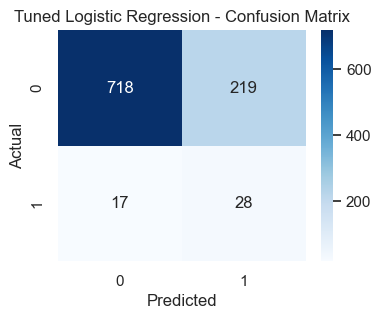

0.7596741344195519

In [218]:
# Applying the hyperparameters
tuned_logistic_regression = LogisticRegression(C=0.1, solver='liblinear')
tuned_logistic_regression.fit(X_train, y_train)
evaluate_model(tuned_logistic_regression, X_train, X_test, y_train, y_test, "Tuned Logistic Regression")

## Conclusion
The models have different strengths and weaknesses. Random forest has the highest accuracy however this is since it very rarely predicts the stroke class leading to a high false negative rate which could be very bad in healthcare applications and therefore the best performing model in my opinion is the logistic regression even though it has a worse accuracy since it has a lower false negative rate thus missing less cases of stroke, but this all depends on what the user wants to prioritize.